feature engineering to prepare training data for XGBoost and logistic regression.
1. Build a switcher where I can turn on and off each feature engineering step. In the notebook. should I still build the feature engineering steps on top of each other? i.e. ohe on imputed df.
2. How to handle outliers? We don't want to remove it, and not useful for xgboost anyways so leaving them untouched for now.
4. scaling the data with minmax, not very helpful for xgboost but still done it in case we are trying other algorithms
5. Mutual information evaluation after all the preprocessing
6. Build a base model evalution for the dataset, which is evaluated by recall@5% because it's highly imbalanced. 

# 1. Setup

## 1.1 Import libraries and reading data

In [1]:
import yaml
with open ("/Users/zoe/Documents/Bank-account-fraud/params.yaml") as p:
    params = yaml.safe_load(p)
params

{'data_location': '/Users/zoe/Documents/Bank-account-fraud/data/Base_backup.csv',
 'output_location': '/Users/zoe/Documents/Bank-account-fraud/output'}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')

from pylab import rcParams

import seaborn as sns
sns.set_style('whitegrid')
my_palette = sns.color_palette("Paired")

from scipy.stats import chi2_contingency, pearsonr

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2

pd.set_option('display.max_columns', 500)

import warnings as wr
wr.filterwarnings('ignore')


In [3]:
df_base = pd.read_csv(params['data_location'])
df = df_base.copy()

### Helper functions

In [6]:
# split categorical and numerical features
def split_num_cat(df):
    """
    Function to split columns into two, one having categorical features and another having numerical feautures
    Parameters
    ----------
    df : dataframe
            pass in full dataframe
    ----------
    Returns: 
        a list of categorical features
        a list of numerical features
    """
    categorical_features = []
    numerical_features = []

    for x in df.columns: 
        if df[x].nunique() > 12:
            numerical_features.append(x)
        elif df[x].nunique() >=2:
            categorical_features.append(x)

    if 'fraud_bool' in categorical_features:
        categorical_features.remove('fraud_bool')
    
    return categorical_features, numerical_features

def drop_unnecessary_columns(df, column_name):
    """
    Function to delete the list of columns 
    Parameters
    ----------
    df : dataframe
            pass in full dataframe
    column_name : list
            pass in list of full column
    ----------
    Returns: Dataframe
    """
    df = df.drop(column_name, axis=1)
    return df

## 1.2 Drop features with no variance

In [4]:
constant_feature =[]
for x in df.columns:
    if df[x].nunique() == 1:
        constant_feature.append(x)

print("Constant features:", constant_feature)

Constant features: ['device_fraud_count']


In [7]:
df = drop_unnecessary_columns(df, df[constant_feature])

### Change the dataype of some of the categorical features into type boolean beacuse some of the categorical features are loaded as numerical 

In [8]:
binary_features = df.columns[df.nunique() == 2].tolist()
binary_features.remove('source')
# Convert these features to boolean
df[binary_features] = df[binary_features].astype(bool)

# Verify changes
print(df[binary_features].dtypes)

fraud_bool            bool
email_is_free         bool
phone_home_valid      bool
phone_mobile_valid    bool
has_other_cards       bool
foreign_request       bool
keep_alive_session    bool
dtype: object


## 1.3 Train test split

In [9]:
y = df["fraud_bool"]
X = df.drop(columns=['fraud_bool'], axis = 1)

In [10]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [11]:
X_train.shape

(800000, 30)

In [12]:
y_train.shape

(800000,)

In [13]:
X_train.describe

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
566853,0.1,0.222901,-1,34,20,0.002312,-1.496044,AB,1182,2791.172965,4762.243085,5015.945233,15,13,CD,10,True,BB,False,True,1,False,200.0,False,INTERNET,4.414680,macintosh,True,1,4
382311,0.6,0.674702,-1,57,30,0.008431,-1.238635,AB,5853,7083.091158,3963.781306,5613.713292,21,4,CB,66,True,BB,True,True,10,True,200.0,False,INTERNET,11.173249,linux,True,1,2
241519,0.1,0.353635,49,2,40,9.409570,-1.206656,AC,325,2753.342399,4242.331097,5497.987249,1,14,CA,87,False,BB,False,True,-1,False,200.0,False,INTERNET,9.994302,linux,True,1,1
719220,0.9,0.152110,-1,15,40,0.010081,-1.559458,AB,2768,4165.481939,3311.035487,4235.241053,14,5,CA,96,True,BC,False,True,31,True,200.0,False,INTERNET,1.460976,linux,True,1,5
905718,0.6,0.911744,-1,277,20,0.000377,-1.438505,AB,921,432.037142,3116.702228,4316.317490,9,27,CA,159,True,BE,True,True,10,True,200.0,False,INTERNET,4.292971,windows,True,1,7


In [14]:
categorical_features, numerical_features = split_num_cat(df)
print('Categorical features:', categorical_features)
print('Numerical features:', numerical_features)

Categorical features: ['income', 'customer_age', 'payment_type', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'month']
Numerical features: ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes']


# 2. Handle missing values¶

XGBoost supports missing values by default. In tree algorithms, branch directions for missing values are learned during training. And the gblinear booster treats missing values as zeros.

We still choose to handle missing values in case of we are using any other types of models. 
Also for features with high percentage of missing values, we choose to add an additional column to indicate where the value is missing, so the model can still learn from missing values. 

In [19]:
# Get names of columns with missing values
missing_value_val = [x for x in X_train.columns if (X_train[x].min() == -1)]

print("Features with missing values represented by -1:")
print(missing_value_val)

# Replace all missing value (-1) with NaN
X_train[missing_value_val] = X_train[missing_value_val].replace(-1, np.nan)
X_test[missing_value_val] = X_test[missing_value_val].replace(-1, np.nan)

Features with missing values represented by -1:
['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']


device_distinct_emails_8w: with median/mean/mode all = 1

session_length_in_minutes: impute with median, skewed to the right

current_address_months_count: use median

prev_address_months_count: use median as the data is skewed to the right

bank_months_count: # How old is previous account (if held) in months. Ranges between [−1, 31] months (-1 is a missing value). ... so fill with 0.

In [20]:
df_train_imputed = X_train.copy()
df_test_imputed = X_test.copy()

In [21]:
# For features with missing_vals_percentage < 1, impute missing values with the median of the group 
columns_to_impute = ['current_address_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']

medians = {}
for column in columns_to_impute:
    medians[column] = df_train_imputed[column].median()

for column in columns_to_impute:
    df_train_imputed[column] = df_train_imputed[column].fillna(medians[column])
    df_test_imputed[column] = df_test_imputed[column].fillna(medians[column])

# Verify no more null values
print((df_train_imputed[columns_to_impute].isna()).sum())
print((df_test_imputed[columns_to_impute].isna()).sum())

current_address_months_count    0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64
current_address_months_count    0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64


In [22]:
# For bank_months_count, fill missing data with 0s 
# add additional column to indicate where missing value is

df_train_imputed['bank_months_count_was_missing'] = df_train_imputed['bank_months_count'].isna().astype(int)
df_test_imputed['bank_months_count_was_missing'] = df_test_imputed['bank_months_count'].isna().astype(int)

df_train_imputed['bank_months_count'] = df_train_imputed['bank_months_count'].fillna(0)
df_test_imputed['bank_months_count'] = df_test_imputed['bank_months_count'].fillna(0)

In [23]:
df_train_imputed.isna().sum()

income                                   0
name_email_similarity                    0
prev_address_months_count           570300
current_address_months_count             0
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                        0
email_is_free                            0
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                        0
has_other_cards                          0
proposed_credit_limit                    0
foreign_req

#### Imputation for prev_address_months_count
Longer current address durations correlate with higher missing values in months_in_previous_address, it indicates the missing values are likely not missing at random. Since the missing value correlates with current_address_months_count, use its value as a condition for imputation.

In [24]:
bin_edges = pd.cut(df_train_imputed['current_address_months_count'], 12, retbins=True)[1]

df_train_imputed['current_address_bucket'] = pd.cut(df_train_imputed['current_address_months_count'], bins=bin_edges)
df_test_imputed['current_address_bucket'] = pd.cut(df_test_imputed['current_address_months_count'], bins=bin_edges)

bucket_medians = df_train_imputed.groupby('current_address_bucket')['prev_address_months_count'].median()

df_train_imputed['prev_address_months_count_was_missing'] = df_train_imputed['prev_address_months_count'].isna().astype(int)
df_test_imputed['prev_address_months_count_was_missing'] = df_test_imputed['prev_address_months_count'].isna().astype(int)

df_train_imputed['prev_address_months_count'] = df_train_imputed.groupby('current_address_bucket')['prev_address_months_count'].transform(
    lambda x: x.fillna(x.median())
)

# Impute test set using training bucket medians
df_test_imputed['prev_address_months_count'] = df_test_imputed.apply(
    lambda row: bucket_medians[row['current_address_bucket']] if pd.isna(row['prev_address_months_count']) and row['current_address_bucket'] in bucket_medians else row['prev_address_months_count'], axis=1
)

df_train_imputed = df_train_imputed.drop("current_address_bucket", axis=1)
df_test_imputed = df_test_imputed.drop("current_address_bucket", axis=1)

In [25]:
df_train_imputed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
income,800000.0,0.562838,0.290284,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,800000.0,0.493679,0.289083,1.434550e-06,0.225180,0.492253,0.755595,0.999999
prev_address_months_count,800000.0,51.640779,37.007722,5.000000e+00,33.000000,51.000000,56.000000,381.000000
current_address_months_count,800000.0,86.881245,88.270189,0.000000e+00,20.000000,53.000000,130.000000,428.000000
customer_age,800000.0,33.683575,12.023340,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,800000.0,1.024581,5.384940,4.036860e-09,0.007184,0.015171,0.026328,78.456904
intended_balcon_amount,800000.0,8.666942,20.255749,-1.553055e+01,-1.181387,-0.830680,4.984334,112.956928
zip_count_4w,800000.0,1572.691783,1005.553072,1.000000e+00,894.000000,1263.000000,1943.000000,6700.000000
velocity_6h,800000.0,5664.123809,3010.204130,-1.706031e+02,3435.962936,5317.126477,7681.772107,16640.749743
velocity_24h,800000.0,4768.744070,1478.809582,1.320284e+03,3592.988203,4749.005380,5750.629217,9506.896596


In [26]:
# Drop the temporary bucket column
# df_train_imputed = df_train_imputed.drop("current_address_bucket", axis=1)
# df_test_imputed = df_test_imputed.drop("current_address_bucket", axis=1)

# Verify results
print("Train set null values after imputation:")
print((df_train_imputed[missing_value_val].isna()).sum())

print("\nTest set null values after imputation:")
print((df_test_imputed[missing_value_val].isna()).sum())

Train set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64

Test set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64


## 3. One-hot encode for categorical features

In [27]:
X_train = df_train_imputed.copy()
X_test = df_test_imputed.copy()

# One-hot encoding for categorical featuers with dtype as 'object'
object_features = [col for col in X_train.columns if X_train[col].dtypes == 'object']
print(object_features)

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [29]:
for i in object_features:
    print(i, '\n', X_train[i].unique(), '\n')

payment_type 
 ['AB' 'AC' 'AA' 'AD' 'AE'] 

employment_status 
 ['CD' 'CB' 'CA' 'CF' 'CE' 'CC' 'CG'] 

housing_status 
 ['BB' 'BC' 'BE' 'BA' 'BD' 'BF' 'BG'] 

source 
 ['INTERNET' 'TELEAPP'] 

device_os 
 ['macintosh' 'linux' 'windows' 'other' 'x11'] 



In [30]:
df_train_encoded = X_train.copy()
df_test_encoded = X_test.copy()

In [31]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

ohe_X_train = pd.DataFrame(ohe.fit_transform(df_train_encoded[object_features]))

ohe_X_test = pd.DataFrame(ohe.transform(df_test_encoded[object_features]))

ohe_X_train.index = df_train_encoded.index
ohe_X_test.index = df_test_encoded.index

ohe_feature_names = ohe.get_feature_names_out(input_features=object_features)
ohe_X_train.columns = ohe_feature_names
ohe_X_test.columns = ohe_feature_names

num_X_train = df_train_encoded.drop(object_features, axis=1)
num_X_test = df_test_encoded.drop(object_features, axis=1)

X_train_encoded = pd.concat([num_X_train, ohe_X_train], axis=1)
# X_train = X_train_encoded.drop(object_features, axis=1)
X_test_encoded = pd.concat([num_X_test, ohe_X_test], axis=1)
# X_test = X_test_encoded.drop(object_features, axis=1)

In [34]:
X_train_encoded.describe()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month,bank_months_count_was_missing,prev_address_months_count_was_missing,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.562838,0.493679,51.640779,86.881245,33.683575,1.024581e+00,8.666942,1572.691783,5664.123809,4768.744070,4856.113352,184.627865,9.502435,131.055336,11.100916,516.355675,7.560475,1.019105,3.289231,0.253607,0.712875,0.258252,0.370686,0.252069,0.118703,0.000290,0.730457,0.138044,0.037816,0.026511,0.022756,0.043951,0.000464,0.169824,0.260911,0.371921,0.026196,0.169220,0.001677,0.000250,0.992920,0.007080,0.332508,0.053678,0.342805,0.263790,0.007220
std,0.290284,0.289083,37.007722,88.270189,12.023340,5.384940e+00,20.255749,1005.553072,3010.204130,1478.809582,919.994441,459.934773,5.033803,69.742814,11.875727,487.806283,8.034326,0.176621,2.209984,0.435076,0.452421,0.437674,0.482989,0.434201,0.323438,0.017027,0.443722,0.344946,0.190752,0.160650,0.149126,0.204987,0.021530,0.375478,0.439132,0.483318,0.159719,0.374946,0.040923,0.015809,0.083844,0.083844,0.471112,0.225380,0.474647,0.440687,0.084663
min,0.100000,0.000001,5.000000,0.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1320.283991,2825.748405,0.000000,0.000000,-169.000000,0.000000,190.000000,0.000872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.300000,0.225180,33.000000,20.000000,20.000000,7.183933e-03,-1.181387,894.000000,3435.962936,3592.988203,4268.319057,1.000000,6.000000,83.000000,0.000000,200.000000,3.121877,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.600000,0.492253,51.000000,53.000000,30.000000,1.517071e-02,-0.830680,1263.000000,5317.126477,4749.005380,4913.667485,9.000000,9.000000,122.000000,5.000000,200.000000,5.123322,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.800000,0.755595,56.000000,130.000000,40.000000,2.632796e-02,4.984334,1943.000000,7681.772107,5750.629217,5487.721416,25.000000,13.000000,178.000000,25.000000,500.000000,8.870898,1.0

# 4. Handle outliers 

In [35]:
X_train = X_train_encoded.copy()
X_test = X_test_encoded.copy()

# Function to calculate the percentage of outliers in a series
def outlier_percentage(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((series < lower_bound) | (series > upper_bound)).sum()
    return (outliers / len(series)) * 100

# Apply to numerical variables
outlier_percentages = X_train[numerical_features].apply(outlier_percentage)

# Display the outlier percentages
print(outlier_percentages)

name_email_similarity                0.000000
prev_address_months_count            5.987000
current_address_months_count         4.142875
days_since_request                   9.477125
intended_balcon_amount              22.265250
zip_count_4w                         6.002250
velocity_6h                          0.892500
velocity_24h                         0.299625
velocity_4w                          0.000000
bank_branch_count_8w                17.557250
date_of_birth_distinct_emails_4w     0.978250
credit_risk_score                    0.874500
bank_months_count                    0.000000
session_length_in_minutes            7.897500
dtype: float64


In [36]:
# Function to calculate the IQR bounds
def remove_outliers(df, columns):
    clean_df = df.copy()
    for column in columns:
        Q1 = clean_df[column].quantile(0.25)
        Q3 = clean_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    return clean_df

# Remove outliers from df_train_imputed
df_cleaned = remove_outliers(X_train, numerical_features)

# Calculate percentage of rows retained
rows_retained = (len(df_cleaned) / len(df_train_imputed)) * 100
print(f"Percentage of data retained: {rows_retained:.2f}%")

Percentage of data retained: 44.13%


<Axes: xlabel='bank_branch_count_8w'>

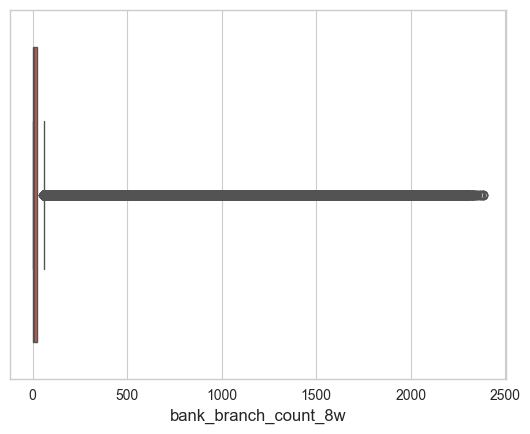

In [177]:
sns.boxplot(x=X_train["bank_branch_count_8w"])

# 5. Scaling

help with unsupervised learning, minimise bias against one variabel 

In [77]:
X_train = X_train_encoded.copy()
X_test = X_test_encoded.copy()

X_train[numerical_features].describe()

,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,session_length_in_minutes
count,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.493679,51.640779,86.881245,1.024581e+00,8.666942,1572.691783,5664.123809,4768.744070,4856.113352,184.627865,9.502435,131.055336,11.100916,7.560475
std,0.289083,37.007722,88.270189,5.384940e+00,20.255749,1005.553072,3010.204130,1478.809582,919.994441,459.934773,5.033803,69.742814,11.875727,8.034326
min,0.000001,5.000000,0.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1320.283991,2825.748405,0.000000,0.000000,-169.000000,0.000000,0.000872
25%,0.225180,33.000000,20.000000,7.183933e-03,-1.181387,894.000000,3435.962936,3592.988203,4268.319057,1.000000,6.000000,83.000000,0.000000,3.121877
50%,0.492253,51.000000,53.000000,1.517071e-02,-0.830680,1263.000000,5317.126477,4749.005380,4913.667485,9.000000,9.000000,122.000000,5.000000,5.123322
75%,0.755595,56.000000,130.000000,2.632796e-02,4.984334,1943.000000,7681.772107,5750.629217,5487.721416,25.000000,13.000000,178.000000,25.000000,8.870898
max,0.999999,381.000000,428.000000,7.845690e+01,112.956928,6700.000000,16640.749743,9506.896596,6994.764201,2385.000000,39.000000,386.000000,32.000000,83.376775


In [75]:
# X_train_scaled = X_train.copy()
# X_test_scaled = X_test.copy()

# from sklearn.preprocessing import MinMaxScaler

# minmax_scaler = MinMaxScaler()

# scaled_train = minmax_scaler.fit_transform(X_train_scaled[numerical_features])
# scaled_test = minmax_scaler.transform(X_test_scaled[numerical_features])

# # add new columns scaled features while keeping the original feature with the unscaled values. 
# for i, feature in enumerate(numerical_features):
#     X_train_scaled['scaled_' + feature] = scaled_train[:, i]
#     X_test_scaled['scaled_' + feature] = scaled_test[:, i]

# X_train_scaled.describe()

### Robust Scaler
https://proclusacademy.com/blog/robust-scaler-outliers/

In [92]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

from sklearn.preprocessing import RobustScaler
 
robust_scaler = RobustScaler()

scaled_train = robust_scaler.fit_transform(X_train_scaled[numerical_features])
scaled_test = robust_scaler.transform(X_test_scaled[numerical_features])

# add new columns scaled features while keeping the original feature with the unscaled values. 
for i, feature in enumerate(numerical_features):
    X_train_scaled['scaled_' + feature] = scaled_train[:, i]
    X_test_scaled['scaled_' + feature] = scaled_test[:, i]

X_train_scaled.describe()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month,bank_months_count_was_missing,prev_address_months_count_was_missing,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,scaled_name_email_similarity,scaled_prev_address_months_count,scaled_current_address_months_count,scaled_days_since_request,scaled_intended_balcon_amount,scaled_zip_count_4w,scaled_velocity_6h,scaled_velocity_24h,scaled_velocity_4w,scaled_bank_branch_count_8w,scaled_date_of_birth_distinct_emails_4w,scaled_credit_risk_score,scaled_bank_months_count,scaled_session_length_in_minutes
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000,800000.000000,8.000000e+05,8.000000e+05,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,0.562838,0.493679,51.640779,86.881245,33.683575,1.024581e+00,8.666942,1572.691783,5664.123809,4768.744070,4856.113352,184.627865,9.502435,131.055336,11.100916,516.355675,7.560475,1.019105,3.289231,0.253607,0.712875,0.258252,0.370686,0.252069,0.118703,0.000290,0.730457,0.138044,0.037816,0.026511,0.022756,0.043951,0.000464,0.169824,0.260911,0.371921,0.026196,0.169220,0.001677,0.000250,0.992920,0.007080,0.332508,0.053678,0.342805,0.263790,0.007220,0.002689,0.027860,0.308011,5.272720e+01,1.540391,0.295226,0.081727,9.148273e-03,-4.719864e-02,7.317828,0.071776,0.095319,0.244037,0.423925
std,0.290284,0.289083,37.007722,88.270189,12.023340,5.384940e+00,20.255749,1005.553072,3010.204130,1478.809582,919.994441,459.934773,5.033803,69.742814,11.875727,487.806283,8.034326,0.176621,2.209984,0.435076,0.452421,0.437674,0.482989,0.434201,0.323438,0.017027,0.443722,0.344946,0.190752,0.160650,0.149126,0.204987,0.021530,0.375478,0.439132,0.483318,0.159719,0.374946,0.040923,0.015809,0.083844,0.083844,0.471112,0.225380,0.474647,0.440687,0.084663,0.545014,1.609031,0.802456,2.812857e+02,3.285220,0.958583,0.708982,6.853826e-01,7.544634e-01,19.163949,0.719115,0.734135,0.475029,1.397512
min,0.100000,0.000001,5.000000,0.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,1320.283991,2825.748405,0.000000,0.000000,-169.000000,0.000000,190.000000,0.000872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.928051,-2.000000,-0.481818,-7.924511e-01,-2.384129,-1.203051,-1.292505,-1.589107e+00,-1.712248e+00,-0.375000,-1.285714,-3.063158,-0.200000,-0.891013
25%,0.300000,0.225180,33.000000,20.000000,20.000000,7.183933e-03,-1.181387,894.00

# 6. Binning

maybe bin the bank_months_count, maybe not too useful... but do it might as well, to turn it into a categorical variable for easier visualization
don't want to bin any other features as we don't want to lose details of the data 

In [122]:
X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()

X_train['bank_months_count'].unique()

array([ 1., 10.,  0., 31., 25.,  5., 28., 21., 15., 26., 30., 11., 22.,
       29., 23.,  2., 20.,  6.,  7.,  4., 19., 27.,  3., 16.,  9., 24.,
       18., 14., 12., 32.,  8., 17., 13.])

In [123]:
# Define bins where the first bin includes only 0 and the rest are grouped in equal intervals of 4
bins = [0, 1] + [i for i in range(5, 37, 4)] 

# Define labels for each bin
labels = ['0', '1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28', '29-32']

# Bin the 'bank_months_count' feature with labels
X_train['bank_months_count_binned'] = pd.cut(
    X_train['bank_months_count'], bins=bins, labels=labels, include_lowest=True, right=False
)
X_test['bank_months_count_binned'] = pd.cut(
    X_test['bank_months_count'], bins=bins, labels=labels, include_lowest=True, right=False
)

# Convert the binned column to type object
X_train['bank_months_count_binned'] = X_train['bank_months_count_binned'].astype(str)
X_test['bank_months_count_binned'] = X_test['bank_months_count_binned'].astype(str)

# Display the bin ranges and their respective counts
bin_counts = X_train['bank_months_count_binned'].value_counts().sort_index()

print("Bin ranges and counts:")
print(bin_counts)

Bin ranges and counts:
bank_months_count_binned
0        202886
1-4      186125
13-16     51345
17-20     31604
21-24     30427
25-28    119801
29-32     86900
5-8       37373
9-12      53539
Name: count, dtype: int64


In [124]:
bin_counts.sum()

np.int64(800000)

In [125]:
X_train['bank_months_count_binned'] = pd.Categorical(
    X_train['bank_months_count_binned'],
    categories=['0', '1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28', '29-32'],
    ordered=True
)

X_test['bank_months_count_binned'] = pd.Categorical(
    X_test['bank_months_count_binned'],
    categories=['0', '1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28', '29-32'],
    ordered=True
)

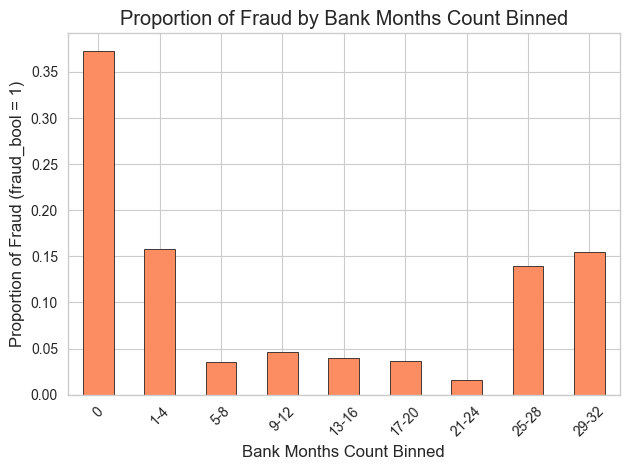

In [126]:
X_train['fraud_bool'] = y_train
fraud_proportion = (
    X_train.groupby('bank_months_count_binned')['fraud_bool']
    .mean()
    .reindex(labels)
)

# Calculate the proportion of fraud_bool = 1 for each category relative to the total data
plot_data = (
    df_train_binned[df_train_binned['fraud_bool'] == 1]['bank_months_count_binned']
    .value_counts(normalize=True)
    .reindex(df_train_binned['bank_months_count_binned'].cat.categories)  # Reorder based on the defined categories
)

# Plot the proportion for fraud_bool = 1
plot_data.plot(kind='bar', color='#fc8d62', edgecolor='black')
plt.xlabel('Bank Months Count Binned')
plt.ylabel('Proportion of Fraud (fraud_bool = 1)')
plt.title('Proportion of Fraud by Bank Months Count Binned')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
X_train = X_train.drop(columns=['fraud_bool'])

In [127]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 566853 to 121958
Data columns (total 68 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   income                                   800000 non-null  float64 
 1   name_email_similarity                    800000 non-null  float64 
 2   prev_address_months_count                800000 non-null  float64 
 3   current_address_months_count             800000 non-null  float64 
 4   customer_age                             800000 non-null  int64   
 5   days_since_request                       800000 non-null  float64 
 6   intended_balcon_amount                   800000 non-null  float64 
 7   zip_count_4w                             800000 non-null  int64   
 8   velocity_6h                              800000 non-null  float64 
 9   velocity_24h                             800000 non-null  float64 
 10  velocity_4w         

# Feature Selection

# Mutual Information

In [128]:
X = X_train.copy()
y = y_train.copy()

# Label encoding for categoricals
for colname in X.select_dtypes(["category", "object"]):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [129]:
discrete_features

income                                     False
name_email_similarity                      False
prev_address_months_count                  False
current_address_months_count               False
customer_age                                True
                                           ...  
scaled_date_of_birth_distinct_emails_4w    False
scaled_credit_risk_score                   False
scaled_bank_months_count                   False
scaled_session_length_in_minutes           False
bank_months_count_binned                    True
Length: 68, dtype: bool

In [130]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores 

housing_status_BA                   0.004948
credit_risk_score                   0.003648
prev_address_months_count           0.002952
proposed_credit_limit               0.002771
date_of_birth_distinct_emails_4w    0.002691
                                      ...   
payment_type_AC                     0.000000
foreign_request                     0.000000
housing_status_BB                   0.000000
month                               0.000000
employment_status_CG                0.000000
Name: MI Scores, Length: 68, dtype: float64

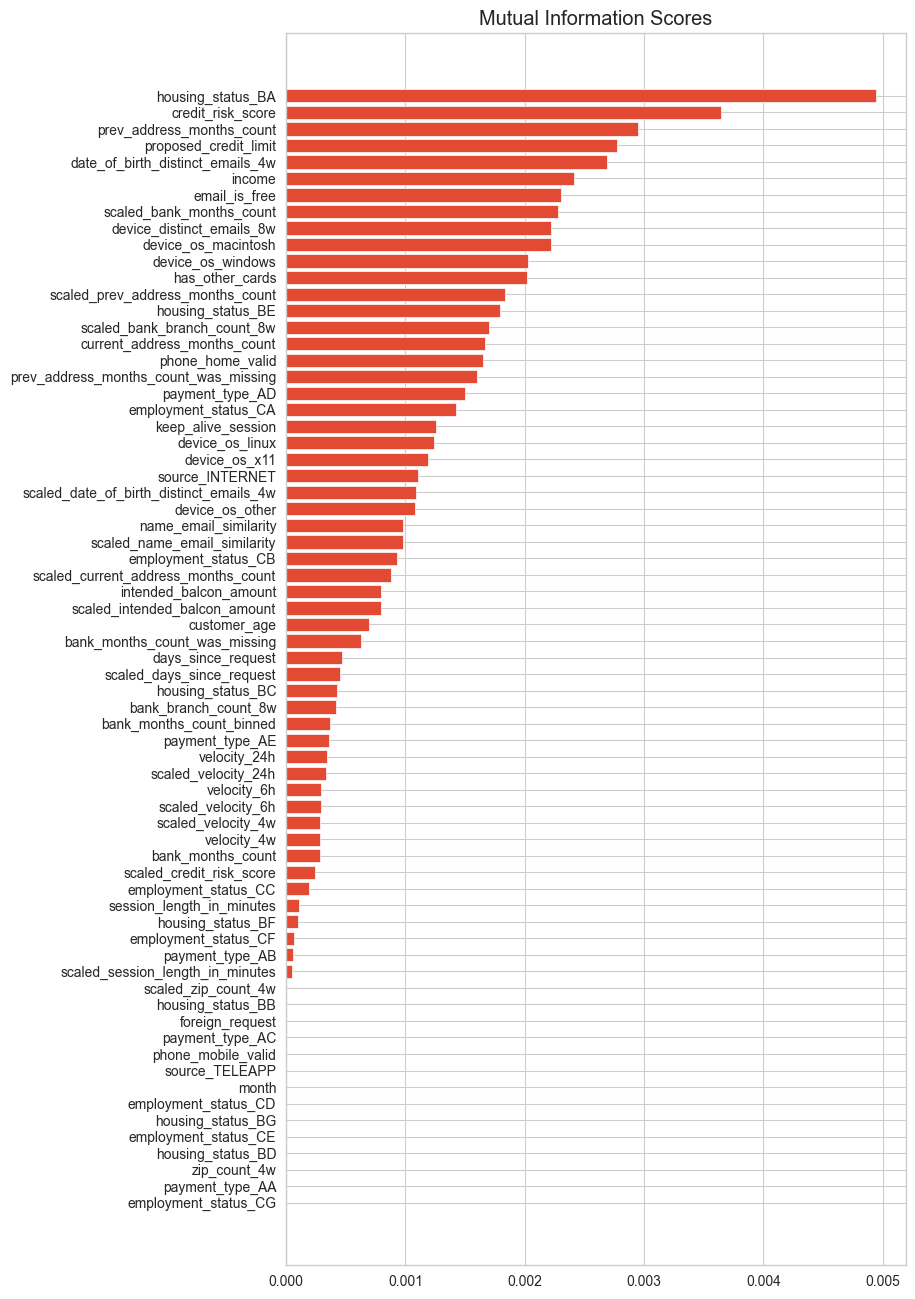

In [132]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 16))
plot_mi_scores(mi_scores)

MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

# Creating Features

Tips on Creating Features

It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

Linear models learn sums and differences naturally, but can't learn anything more complex.
Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.

Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once. 

# Target Encoding

# Score baseline model

In [133]:
# Metric for bank account fraud is recall @5% FPR
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, recall_score

def score_dataset(X, y, model=XGBClassifier()):
    # Label encoding for categorical features
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()

    model.fit(X, y)

    y_proba = model.predict_proba(X)[:, 1]

    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_proba)

    # Find the recall where the FPR is approximately 5%
    recall_at_5_fpr = tpr[np.searchsorted(fpr, 0.05)]

    return recall_at_5_fpr

In [134]:
X_new = X.join([X_1, X_2, X_3, X_4, X_5])
baseline_score = score_dataset(X_new, y)

print(f"Baseline Recall at 5% FPR: {baseline_score:.4f}")

NameError: name 'X_1' is not defined